In [32]:
# https://towardsdatascience.com/generating-new-faces-with-variational-autoencoders-d13cfcb5f0a8

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import seaborn as sns

from RNNxp import vaeRNN

import sys
import time
import random
import numpy as np
import cv2  # conda install opencv
import pickle


import matplotlib.pyplot as plt
from tabulate import tabulate
from utils import printProgressBar

def echo(txt):
    sys.stdout.write('\r {}'.format(txt))
    sys.stdout.flush()

%matplotlib notebook

In [2]:
# load the dataset
import pickle
with open('traj.dat', 'rb') as f:
    dat = pickle.load(f)
    
# prepare the dataset
trn_v, trg_v, trn_p, trg_p = [],[],[],[]

for traj in range(len(dat['vis'])):
    trn_v.append(dat['vis'][traj][0: -1,:,:,:])
    trg_v.append(dat['vis'][traj][1:   ,:,:,:])

    trn_p.append(dat['pos'][traj][0: -1,:])
    trg_p.append(dat['pos'][traj][1:   ,:])


In [3]:
def get_sample(device):
    
    global trn_v, trg_v, trn_p, trg_p
    
    traj = np.random.randint(len(trn_v))
    
    frames = []
    for frame in trn_v[traj]:
        frames.append(frame.sum(axis=2)/255.)
    trn_V = np.stack(frames)
    
    frames = []
    for frame in trg_v[traj]:
        frames.append(frame.sum(axis=2)/255.)
    trg_V = np.stack(frames)
    
    trn_P = trn_p[traj]
    trg_P = trg_p[traj]
    
    visual_input = torch.tensor(trn_V, dtype=torch.float).view(-1, 1, 64, 64).to(device)
    motor_input = torch.tensor(trn_P, dtype=torch.float).view(-1, 2).to(device)
    visual_target = torch.tensor(trg_V, dtype=torch.float).view(-1, 1, 64, 64).to(device)
    motor_target = torch.tensor(trg_P, dtype=torch.float).view(-1, 2).to(device)

    # return trn_V, trg_V, trn_P, trg_P
    return trn_V, trn_P, visual_input, motor_input, visual_target, motor_target


device = 'cuda'
# get one sequence from the dataset:
trn_V, trn_P, visual_input, motor_input, visual_target, motor_target = get_sample(device)

In [4]:
input_size  = 8
hidden_size = 8
output_size = 8
cell_type = 'GRU'
num_rnn_layers = 1


EPOCHS = 50000
device = 'cuda'

criterion = nn.MSELoss()

rnn = vaeRNN(cell_type, input_size, hidden_size, output_size, num_rnn_layers).to(device)

# rnn.load_state_dict(torch.load('checkpoint'))

hidden = rnn.initHidden(device=device)
IMG, joints, visual_input, motor_input, visual_target, motor_target = get_sample(device)
# visual_output, motor_output, hidden = rnn(visual_input, motor_input, hidden)
visual_output, motor_output, hidden, mu, logsig = rnn(visual_input, motor_input, hidden, True)


In [5]:
# rnn.load_state_dict(torch.load('checkpoint'))

In [6]:
# torch.save(rnn.state_dict(), 'checkpoint')

In [7]:
VLOSS, MLOSS, KLOSS = [], [], []
name = ''.join(random.sample('abcdefgh1234567890', 10))
writer = SummaryWriter('runs/' + name)


def loss_balancer(vl, ml, kl):
    total_loss_ = vl + ml + kl
    visual_mult = total_loss_ / 3.0 / vl
    motor_mult = total_loss_ / 3.0 / ml
    kl_mult = total_loss_ / 3.0 / kl
    s = visual_mult + motor_mult + kl_mult
    return visual_mult/s, motor_mult/s, kl_mult/s

Progress: |-------------------------| 0.0% Complete

<IPython.core.display.Javascript object>


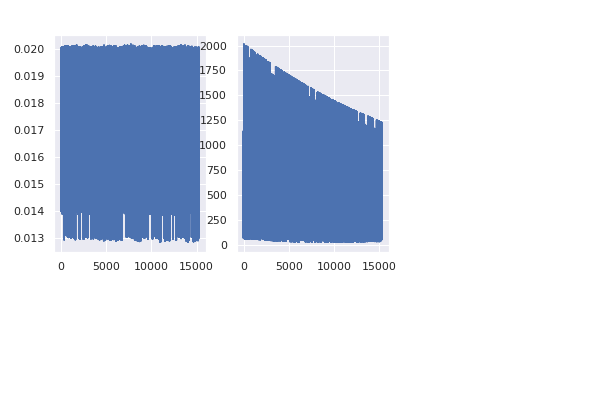

Epoch: 001580 vloss: 0.02 mloss: 341.282501 KLloss: 9.773161 |-------------------------| 3.2% Completeee
Stopped


In [220]:
%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'


rnn.optimizer = optim.Adam(rnn.parameters(), lr=0.0001)
# rnn.optimizer = optim.Adam(rnn.parameters())

mloss_boost = 3

printProgressBar(0, EPOCHS, prefix = 'Progress:', suffix = 'Complete', length = 25)


fig, (ax0, ax1) = plt.subplots(1,2)
fig.show()
i = 0
x = []
y = []
t = time.time()

for epoch in range(EPOCHS):
    try:
        f = open('log.txt', 'a')
        rnn.optimizer.zero_grad()
        
        
        hidden = rnn.initHidden(device) # re-init hidden state to zero
        trn_V, trn_P, visual_input, motor_input, visual_target, motor_target = get_sample(device)

#         visual_output, motor_output, hidden = rnn(visual_input, motor_input, hidden)
        visual_output, motor_output, hidden, mu, logsig = rnn(visual_input, motor_input, hidden, True)

        
        
        motor_loss = criterion(motor_output, motor_target)
        visual_loss = criterion(visual_output, visual_target)
        kl_loss = rnn.KL(mu, logsig)
        
        visual_mult, motor_mult, kl_mult = loss_balancer(visual_loss.item(), motor_loss.item(), kl_loss.item())

        
        loss = motor_mult*motor_loss + visual_mult*visual_loss + kl_loss * kl_mult
        
        
        loss.backward()
        
        writer.add_scalar('motor loss', motor_loss, epoch)
        writer.add_scalar('visual loss', visual_loss, epoch)
        writer.add_scalar('KL loss', kl_loss, epoch)
        
        VLOSS.append(visual_loss.item())
        MLOSS.append(motor_loss.item())
        KLOSS.append(kl_loss.item())
        rnn.optimizer.step()
       
        printProgressBar(epoch + 1,
                         EPOCHS, 
                         prefix=('Epoch: {} vloss: {:.2f} mloss: {:.6f} KLloss: {:.6f}').format(
                             str(epoch).zfill(6),
                             visual_loss.item(),
                             motor_loss.item(),
                             kl_loss.item()), 
                         suffix='Complete', length=25)
       
        if epoch % 1000 == 0:
            torch.save(rnn.state_dict(), 'checkpoint')
            
        if epoch % 100 == 0:
            ax0.plot(VLOSS, c='b')
            ax1.plot(MLOSS, c='b')
            ax2.plot(KLOSS, c='b')
            fig.canvas.draw()
            
    except KeyboardInterrupt:
        %matplotlib inline
        print('\nStopped')
        break
        

In [198]:
# """ with prediction feedback """


# rnn.optimizer = optim.Adam(rnn.parameters(), lr=0.0005)
# # rnn.optimizer = optim.Adam(rnn.parameters())
# pred_fb = 0.1                                 # fraction of feedback at each step (ground truth = 1 - pred_fb)

# printProgressBar(0, EPOCHS, prefix = 'Progress:', suffix = 'Complete', length = 25)
# for epoch in range(EPOCHS):
#     try:
#         if epoch%5 == 0:
#             IMG, joints, visual_input, motor_input, visual_target, motor_target = loadset(device)
        
#         # forward the first step in the sequence:
#         hidden = rnn.initHidden(device=device)
#         visual_output, motor_output, hidden = rnn(visual_input[0].unsqueeze(0),
#                                                   motor_input[0].unsqueeze(0),
#                                                   hidden)  
#         rnn.optimizer.zero_grad()
#         loss = torch.zeros(1,).to(device)
        
#         for i in range(1, motor_input.shape[0]):
#             visual_output, motor_output, hidden = rnn(visual_input[i].unsqueeze(0)*(1-pred_fb) + visual_output*pred_fb,
#                                                       motor_input[i].unsqueeze(0)*(1-pred_fb) + motor_output.unsqueeze(0)*pred_fb,
#                                                       hidden)

#             motor_loss = criterion(motor_output.unsqueeze(0), motor_target[i].unsqueeze(0))
#             visual_loss = criterion(visual_output, visual_target[i].unsqueeze(0))

#             if visual_loss > motor_loss:
#                 motor_loss_mult = visual_loss.item() / motor_loss.item()
#             else:
#                 motor_loss_mult = 1.0

#             l2_reg = torch.zeros(1,).to(device)
#     #         for param in rnn.parameters():
#     #             l2_reg += torch.norm(param)

#     #         loss = motor_loss_mult*motor_loss + visual_loss# + 0.001*l2_reg
#             loss += motor_loss_mult*motor_loss + visual_loss + l2_reg

#         loss.backward()
#         writer.add_scalar('motor loss', motor_loss, epoch)
#         writer.add_scalar('visual loss', visual_loss, epoch)
            
#         VLOSS.append(visual_loss.item())
#         MLOSS.append(motor_loss.item())
#         rnn.optimizer.step()
#         printProgressBar(epoch + 1, EPOCHS, prefix='Epoch: {} vloss: {:.2f} mloss: {:.6f} l2: {:.3f}'.format(epoch, visual_loss.item(), motor_loss.item(), l2_reg.item()), suffix='Complete', length=25)
#         if epoch % 1000 == 0:
#             torch.save(rnn.state_dict(), 'checkpoint')

#     except KeyboardInterrupt:
#         print('\nKeyboard Interrupt')
#         break
        

In [222]:
""" MONITOR """


cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)


trn_V, trn_P, visual_input, motor_input, visual_target, motor_target = get_sample(device)

i = 0
while True:
    try:
        time.sleep(0.1)
        
        im1 = cv2.resize(visual_input[i,:,:].squeeze().cpu().detach().numpy(), (350, 350), interpolation = cv2.INTER_AREA)
        im1 = cv2.normalize(im1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#         visual_output, motor_output, hidden = rnn(visual_input[i,:,:,:].unsqueeze_(0), 
#                                           motor_input[i,:].unsqueeze_(0),
#                                           hidden)
        visual_output, motor_output, hidden, mu, logsig = rnn(visual_input[i,:,:,:].unsqueeze_(0), 
                                          motor_input[i,:].unsqueeze_(0),
                                          hidden, False)
        im2 = cv2.resize(visual_output.squeeze().cpu().detach().numpy(), (350, 350), interpolation = cv2.INTER_AREA)
        im2 = cv2.normalize(im2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        final_frame = cv2.hconcat((im1, im2))
        cv2.imshow('I see', final_frame)
        
        k = cv2.waitKey(3) & 0XFF
        if k== 27 :
            cv2.destroyWindow('I see')
            break
        i += 1
    except:
        cv2.destroyWindow('I see')
        break

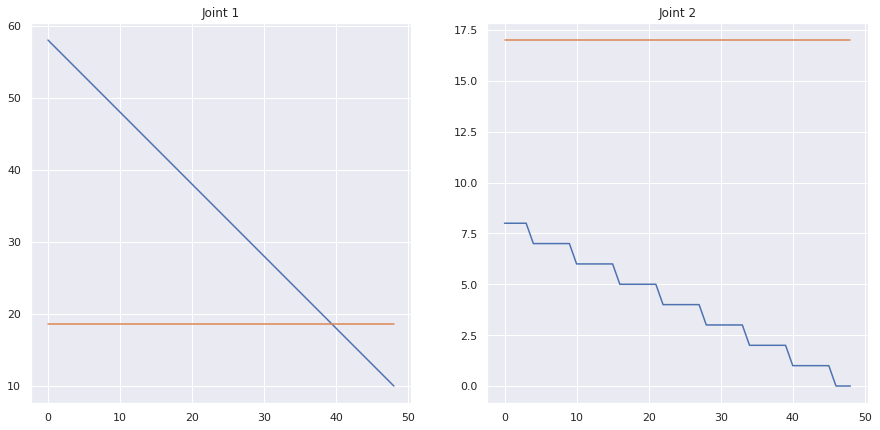

In [223]:
%matplotlib inline

OUT = []


trn_V, trn_P, visual_input, motor_input, visual_target, motor_target = get_sample(device)

for i in range(len(trn_V)):
#     visual_output, motor_output, hidden = rnn(visual_input[i,:,:,:].unsqueeze_(0), 
#                                       motor_input[i,:].unsqueeze_(0),
#                                       hidden)
    
    visual_output, motor_output, hidden, mu, logsig = rnn(visual_input[i,:,:,:].unsqueeze_(0), 
                                  motor_input[i,:].unsqueeze_(0),
                                  hidden, False)
    OUT.append(motor_output.cpu().detach().numpy())
OUT = np.stack(OUT)
IN = motor_input.cpu().detach().numpy()

plt.figure(figsize=(15,7))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(IN[:, i])
    plt.plot(OUT.squeeze()[:, i])
    plt.title('Joint {}'.format(i+1))

# VAE with only FC layers

In [322]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.im_int0 = nn.Linear(4096, 256)
        self.int0_mu = nn.Linear(256, latent_dim)
        self.int0_sig = nn.Linear(256, latent_dim)
        self.lat_int1 = nn.Linear(latent_dim, 256)
        self.int1_im = nn.Linear(256, 4096)
#         self.criterion = nn.MSELoss()
        self.criterion = nn.BCELoss(reduction='sum')
        
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4)
        self.LOSS = []
        self.latent_dim = latent_dim

        
    def forward(self, visual_input, reparameterize=True):
            
        int0 = F.relu(self.im_int0(visual_input))

        # we don't activate the output of the im_mu layer, 
        # because we want mu to be in [-Inf, +Inf]
        mu = self.int0_mu(int0)

        # for convenience, we 'ask' the layer to give us not sigma, but log(sigma).
        # because in the loss, we don't need pure sigma, but log(sigma)
        # likewise, we don't activate the output of the im_sig layer because we want
        # log(sigma) to be in [-Inf, +Inf], and consequently sigma to be in [0, +Inf]
        log_sig = self.int0_sig(int0)

        # Don't forget to transform log(sigma) back to the linspace before you pass
        # it as an argument to the reparametrization function. Sample one 2D point 
        # from a 2D normal distribution with the given mean and sigma
        # NOTE. The commented line below will not work, because gradients cannot flow through
        # stochastic variables. BUT you can add randomly sampled constants to variables
        # without any problem. This is called the 'reparametrization trick' (see the function reparametrize)
        # latent = torch.normal(mean=mu, std=torch.exp(log_sig)) 
        latent = self.reparameterize(mu, log_sig, reparameterize)

        # sidmoid will transform the ouput of the latent layer,
        # becuase the input and output image intensities are chosen to be in [0, 1]
        int1 = F.relu(self.lat_int1(latent))
        decoded = torch.sigmoid(self.int1_im(int1))
    
        return decoded, mu, log_sig
    
    def reparameterize(self, mu, log_sig, reparameterize=True):
        std = torch.exp(log_sig)
        eps = torch.randn_like(std)
        return mu + eps*std if reparameterize else mu
    
    def KL(self, z_mean, z_log_sigma):
        kl_loss = - 0.5 * torch.sum(1.0 + z_log_sigma - z_mean.pow(2) - z_log_sigma.exp())
        return kl_loss
    
    def loss_balancer(self, vl, kl):
        try:
            total_loss_ = vl + kl
            visual_mult = total_loss_ / 2.0 / vl
            kl_mult = total_loss_ / 2.0 / kl
            s = visual_mult + kl_mult
            return visual_mult/s, kl_mult/s
        except:
            return 1.0, 1.0

    def fit(self, EPOCHS=1000):
        MU = []
        printProgressBar(0, EPOCHS, prefix = 'Progress:', suffix = 'Complete', length = 25)
        self.train()
        
        for epoch in range(EPOCHS):
            try:
                # one epoch consists of several batches, spanning the entire dataset

                trn_V, trn_P, visual_input, motor_input, visual_target, motor_target = get_sample(device)
                

                # don't forget to zero grads after each batch. Gradients accumulate 
                # for each sample in a batch.
                self.optimizer.zero_grad() 

                visual_input = visual_input.view(-1, 4096)
                decoded, mu, log_sig = self.forward(visual_input, reparameterize=True)
                MU.append(mu.cpu().detach().numpy())

                kl_loss = self.KL(mu, log_sig)
#                     visual_loss = F.binary_cross_entropy(decoded, example_data, reduction='sum')
                visual_loss = self.criterion(decoded, visual_input)
                
                visual_mult, kl_mult = self.loss_balancer(visual_loss.item(), kl_loss.item())
        
#                 loss = visual_mult*visual_loss + kl_mult*kl_loss
#                 loss = 10000.0*visual_loss + kl_mult
                loss = kl_loss + visual_loss
    
                VLOSS.append(visual_loss.item())
                KLOSS.append(kl_loss.item())

                loss.backward()
                self.optimizer.step()
                
                if epoch % 100 == 0:
                    ax0.plot(VLOSS, c='b')
                    ax1.plot(KLOSS, c='b')
                    ax2.clear()
                    for i in range(mu.shape[1]):
                        sns.distplot(np.vstack(MU)[:,i],
                                     hist = False, kde = True,
                                     kde_kws = {'linewidth': 3},
                                     label = 'latent var. {}'.format(i),
                                     ax=ax2)
                    
                    fig.canvas.draw()
                    MU = []
                
                self.LOSS.append([kl_loss.item(), visual_loss.item()])

                printProgressBar(epoch + 1,
                                 EPOCHS,
                                 prefix='Epoch: {} Dkl: {:.7f}, xent: {:.3f}'.format(
                                     epoch,            
                                     kl_loss.item(),
                                     visual_loss.item()),
                                 suffix='Complete',
                                 length=25)
            except KeyboardInterrupt:
                    %matplotlib inline
                    print('\nKeyboard Interrupt')
                    MU = np.vstack(MU)
                    plt.figure(figsize=(15,5))
                    for i in range(MU.shape[1]):
                        plt.subplot(1,MU.shape[1], i+1)
                        plt.hist(MU[:,i], bins=30)
                    break

In [323]:
latent_dim = 6
vae = VAE(latent_dim).to(device)
VLOSS, KLOSS = [], []

<IPython.core.display.Javascript object>


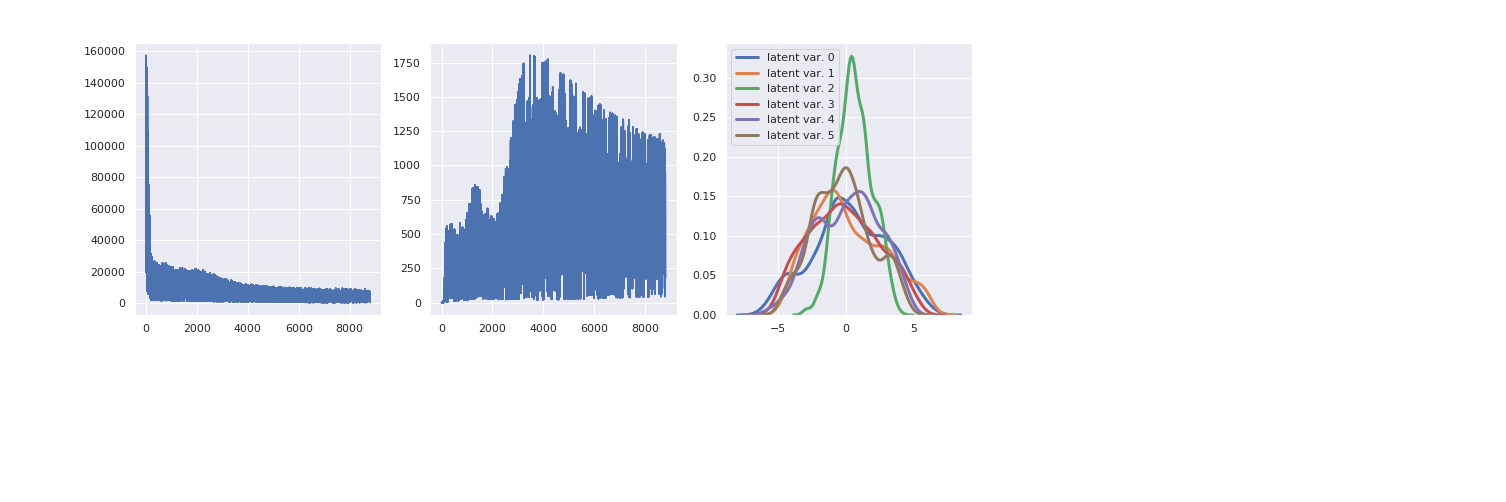

Epoch: 1350 Dkl: 668.2829590, xent: 4205.936 |████---------------------| 18.0% Completee
Keyboard Interrupt


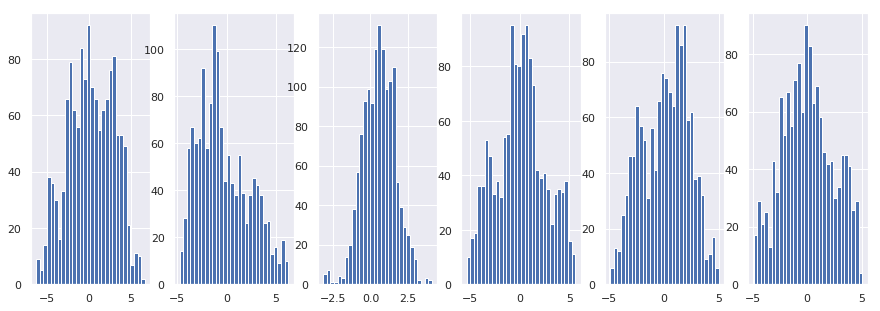

In [325]:
%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(15,5))
fig.show()


vae.fit(7500)

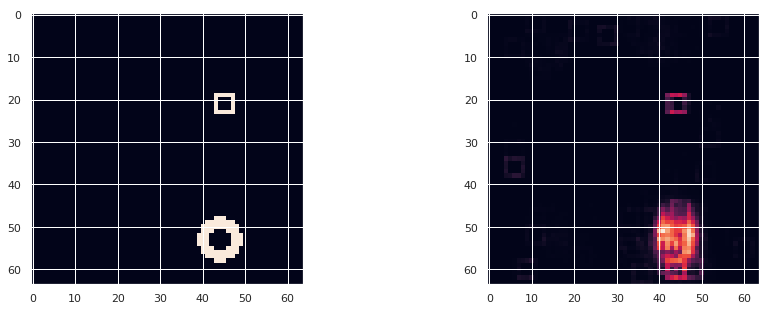

In [328]:
%matplotlib inline

trn_V, trn_P, visual_input, motor_input, visual_target, motor_target = get_sample(device)
visual_input = visual_input.view(-1, 4096)
decoded, mu, sig = vae.forward(visual_input, reparameterize=False)

step = 2

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(visual_input[step,:].view(64,64).cpu().detach().numpy())
plt.subplot(1,2,2)
plt.imshow(decoded[step,:].view(64,64).cpu().detach().numpy())


In [333]:
""" MONITOR """


cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)


trn_V, trn_P, visual_input, motor_input, visual_target, motor_target = get_sample(device)
visual_input = visual_input.view(-1, 4096)
decoded, mu, sig = vae.forward(visual_input, reparameterize=True)

i = 0
while True:
    try:
        time.sleep(0.1)

        
        im1 = cv2.resize(visual_input[i,:].view(64,64).squeeze().cpu().detach().numpy(), (350, 350), interpolation = cv2.INTER_AREA)
        im1 = cv2.normalize(im1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
        
        im2 = cv2.resize(decoded[i,:].view(64,64).squeeze().cpu().detach().numpy(), (350, 350), interpolation = cv2.INTER_AREA)
        im2 = cv2.normalize(im2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        final_frame = cv2.hconcat((im1, im2))
        cv2.imshow('I see', final_frame)
        
        k = cv2.waitKey(3) & 0XFF
        if k== 27 :
            cv2.destroyWindow('I see')
            break
        i += 1
    except:
        cv2.destroyWindow('I see')
        break

# VAE with conv-deconv layers

In [8]:

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()                  # extend the functionality of previously built classes.

        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=(1,1))
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=(1,1))
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=(1,1))
        
        self.fc1 =   nn.Linear(4096, 100)
        
        self.fcmu = nn.Linear(100, latent_dim)
        self.fcsig = nn.Linear(100, latent_dim)
        
        self.fc2 =   nn.Linear(latent_dim, 1024)
        
        self.deconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=128, kernel_size=5, stride=2)
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=6, stride=2)


        self.optimizer = optim.RMSprop(self.parameters(), lr=0.00001)        
    
    def reparameterize(self, mu, logsig, train):
        std = torch.exp(logsig)*0.5                     # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        eps = torch.randn_like(std)
        return mu + eps*std if train else mu   

    def KL(self, mu, logsig):
        Dkl = - 0.5 * torch.sum(1.0 + logsig - mu.pow(2) - logsig.exp())
        return Dkl 
    
    def forward(self, visual_input, train):
        # visual pathway:
        out = F.relu(self.conv1(visual_input))                         # torch.Size([?, 7, 64, 64])
        out = F.relu(self.conv2(out))                                   # torch.Size([?, 28, 32, 32])
        out = F.relu(self.conv3(out))                                   # torch.Size([?, 28, 32, 32])
        out = F.relu(self.conv4(out))                                  # torch.Size([?, 28, 32, 32])

        out = out.view(-1, out.size()[1]*out.size()[2]*out.size()[3])   # torch.Size([?, 7168])
        out = F.relu(self.fc1(out))                                     # torch.Size([?, 500])
              
        mu = self.fcmu(out)                                   # torch.Size([?, 46])      
        logsig = self.fcsig(out)                              # torch.Size([?, 46])
        
        latent = self.reparameterize(mu, logsig, train=train)  # torch.Size([?, 1, 46])
        
        out1 = F.relu(self.fc2(latent).view(-1,1024,1,1))
        out1 = F.relu(self.deconv1(out1))                               # torch.Size([?, 64])
        out1 = F.relu(self.deconv2(out1))                               # torch.Size([?, 64])
        out1 = F.relu(self.deconv3(out1))                              # torch.Size([?, 64])
        out1 = torch.sigmoid(self.deconv4(out1))                               # torch.Size([?, 64])

        return out1, mu, logsig
    
    def reconstruct(self, mu):
        out1 = F.relu(self.fc2(mu).view(-1,1024,1,1))
        out1 = F.relu(self.deconv1(out1))                              # torch.Size([?, 64])
        out1 = F.relu(self.deconv2(out1))                              # torch.Size([?, 64])
        out1 = F.relu(self.deconv3(out1))                              # torch.Size([?, 64])
        out1 = torch.sigmoid(self.deconv4(out1))                       # torch.Size([?, 64])
        return out1
        

In [9]:
latent_dim  = 4
device = 'cuda'
vae = VAE(latent_dim).to(device)
vae.load_state_dict(torch.load('checkpoint_vae_hidden_states'))

<All keys matched successfully>

In [134]:
LOSS = []

<IPython.core.display.Javascript object>


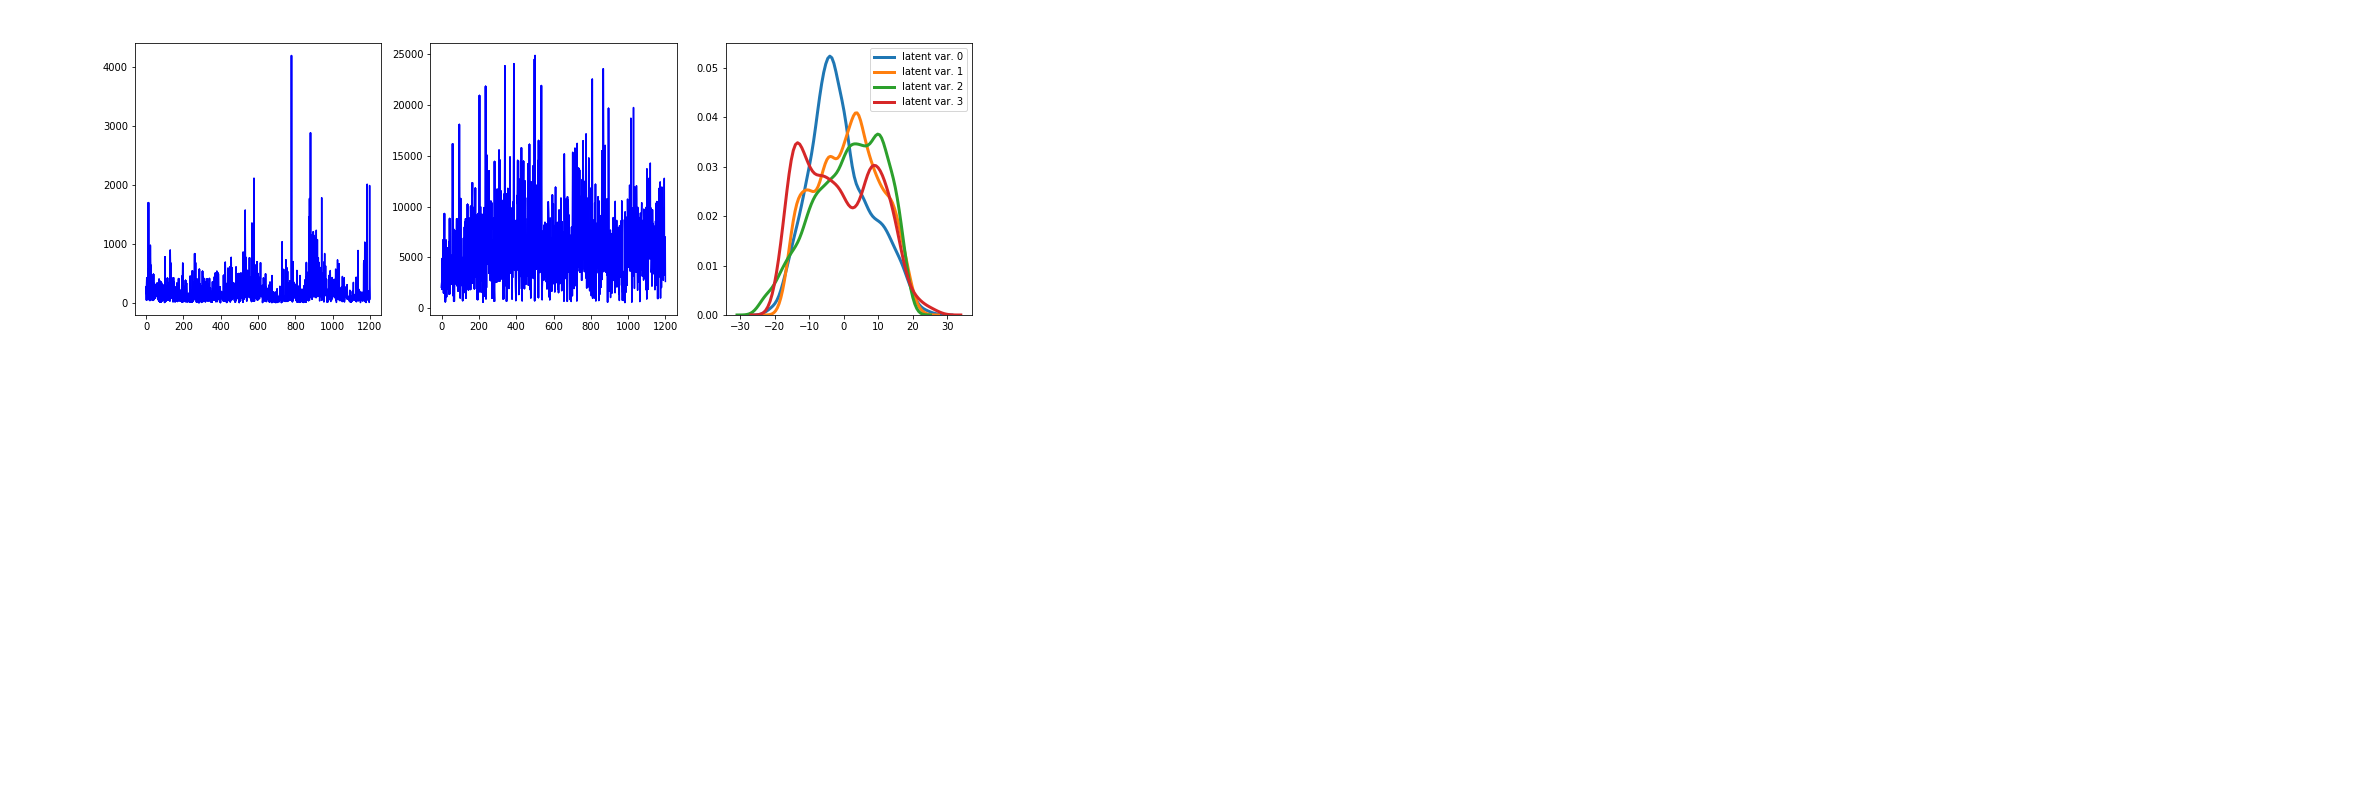

Epoch: 1500 vloss: 633.8680 kloss: 7845.480469 |-------------------------| 0.3% Completeee
Stopped


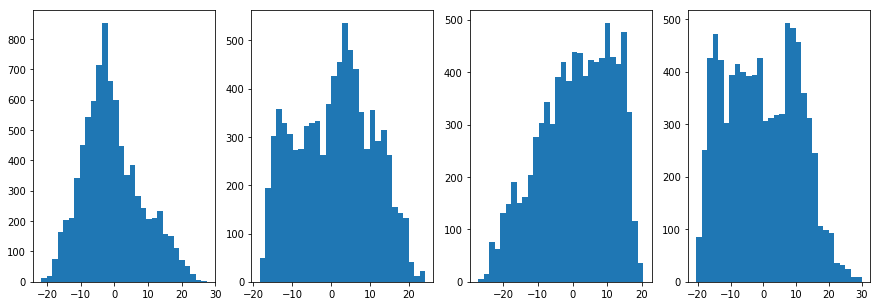

In [135]:
%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(15,5))
fig.show()
MU, KLOSS, VLOSS = [], [],[]

EPOCHS = 500000



# criterion = nn.MSELoss()
criterion = nn.BCELoss(reduction='sum')
vae.optimizer = optim.Adam(vae.parameters(), lr=0.0001)

def loss_balancer(vl, kl):
    try:
        total_loss_ = vl + kl
        visual_mult = total_loss_ / 2.0 / vl
        kl_mult = total_loss_ / 2.0 / kl
        s = visual_mult + kl_mult
        return visual_mult/s, kl_mult/s
    except:
        return 1.0, 1.0


printProgressBar(0, EPOCHS, prefix = 'Progress:', suffix = 'Complete', length = 25)

for epoch in range(EPOCHS):
    try:
        vae.optimizer.zero_grad()
        
        _, _, visual_input, _, _, _ = get_sample(device)

        visual_output, mu, logsig = vae(visual_input, True)
        MU.append(mu.cpu().detach().numpy())

        visual_loss = criterion(visual_output, visual_input)
        kl_loss = vae.KL(mu, logsig)

        visual_mult, kl_mult = loss_balancer(visual_loss.item(), kl_loss.item())
        
#         loss = visual_mult*visual_loss + 100*kl_mult*kl_loss
        loss = 600*visual_loss + kl_loss
        VLOSS.append(visual_loss.item())
        KLOSS.append(kl_loss.item())
        
        
        loss.backward()
        
        vae.optimizer.step()
       
        printProgressBar(epoch + 1, EPOCHS, prefix='Epoch: {} vloss: {:.4f} kloss: {:.6f}'.format(epoch, visual_loss.item(), kl_loss.item()), suffix='Complete', length=25)
        
        LOSS.append([visual_loss.item(), kl_loss.item()])
        if epoch % 300 == 0:
            ax0.plot(VLOSS, c='b')
            ax1.plot(KLOSS, c='b')
            ax2.clear()
            for i in range(mu.shape[1]):
                sns.distplot(np.vstack(MU)[:,i],
                             hist = False,
                             norm_hist = True,
                             kde = True,
                             kde_kws = {'linewidth': 3},
                             label = 'latent var. {}'.format(i),
                             ax=ax2)
            fig.canvas.draw()
            MU = []
            
            
    except KeyboardInterrupt:
        %matplotlib inline
        print('\nStopped')
        MU = np.vstack(MU)
        plt.figure(figsize=(15,5))
        for i in range(MU.shape[1]):
            plt.subplot(1,MU.shape[1], i+1)
            plt.hist(MU[:,i], bins=30)
        break


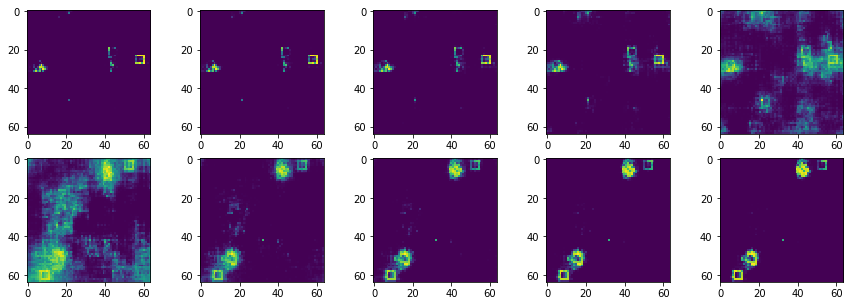

In [10]:
plt.figure(figsize=(15,5))
c = 1
for i in np.linspace(-5, 5, 10):
    reconst = vae.reconstruct(torch.tensor([i,i,0,0], dtype=torch.float).view(1,4).cuda())
    plt.subplot(2,5,c)
    plt.imshow(reconst.cpu().detach().numpy().squeeze())
    c += 1
    

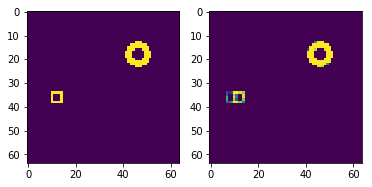

In [11]:
%matplotlib inline

samp = 10

_, _, visual_input, _, _, _ = get_sample(device)

visual_output, mu, logsig = vae(visual_input, False)


plt.subplot(1,2,1)
plt.imshow(visual_input[8,:,:,:].squeeze().cpu().detach().numpy())
plt.subplot(1,2,2)
plt.imshow(visual_output[8,:,:,:].squeeze().cpu().detach().numpy())

Text(0.5,1,'activation of the latent variables for one sequence')

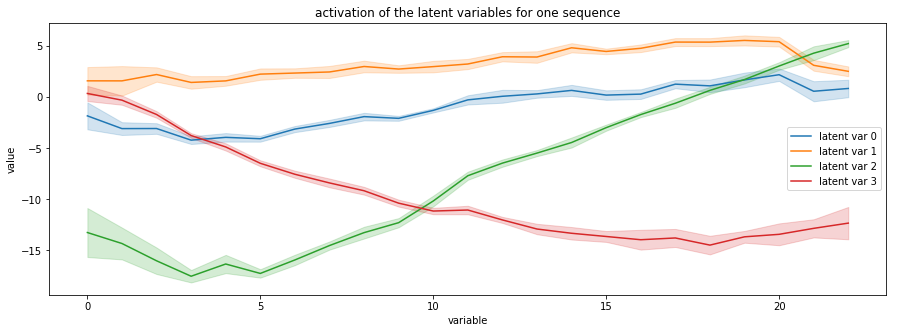

In [22]:
""" MONITOR """


cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)


_, _, visual_input, _, _, _ = get_sample(device)

visual_output, mu, logsig = vae(visual_input, False)

mu = mu.cpu().detach().numpy()
sigma = logsig.cpu().detach().numpy()

i = 0
while True:
    try:
        time.sleep(0.1)
        
        im1 = cv2.resize(visual_input[i,:,:,:].squeeze().cpu().detach().numpy(), (350, 350), interpolation = cv2.INTER_AREA)
        im1 = cv2.normalize(im1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        im2 = cv2.resize(visual_output[i,:,:,:].squeeze().cpu().detach().numpy(), (350, 350), interpolation = cv2.INTER_AREA)
        im2 = cv2.normalize(im2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        final_frame = cv2.hconcat((im1, im2))
        
        
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText = (10,10)
        fontScale              = 0.4
        fontColor              = (255,255,255)
        lineType               = 1

        cv2.putText(final_frame,'Ground truth', (100,20), font, fontScale, fontColor, lineType)
        cv2.putText(final_frame,'Reconstruction', (400,20), font, fontScale, fontColor, lineType)
        cv2.imshow('I see', final_frame)
        
        k = cv2.waitKey(3) & 0XFF
        if k== 27 :
            cv2.destroyWindow('I see')
            break
        i += 1
    except:
        cv2.destroyWindow('I see')
        break

plt.figure(figsize=(15,5))
x = np.linspace(0, len(mu))
for i in range(mu.shape[1]):
    data = mu[:,i] + np.random.rand(10, len(mu)) + np.random.randn(10, len(sigma))*np.exp(sigma[:,i])*40
    df = pd.DataFrame(data).melt()
    sns.lineplot(x="variable", y="value", data=df, ci='sd', label='latent var {}'.format(i))
plt.title('activation of the latent variables for one sequence')

# now we can encode the initial image and 'joint' positions into a latent state and feed it into and RNN for trajectory generation


In [12]:
# torch.save(vae.state_dict(), 'checkpoint_vae_hidden_states')
# vae.load_state_dict(torch.load('checkpoint_vae_hidden_states'))

<All keys matched successfully>

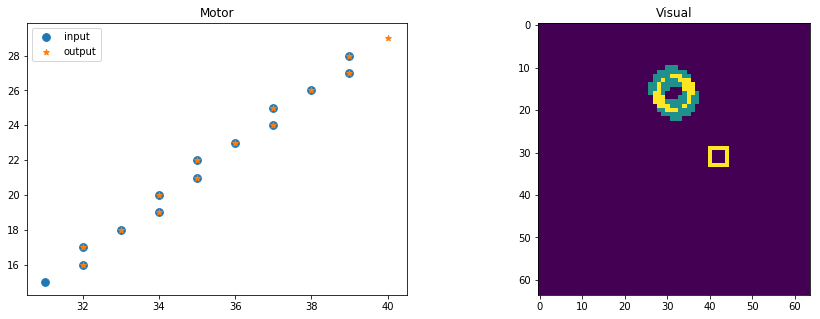

In [26]:
# visualize a training sequence:

%matplotlib inline
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(15,5))
ax0.scatter(motor_input[:,0].cpu(), motor_input[:,1].cpu(), marker='o', s=60, label='input')
ax0.scatter(motor_target[:,0].cpu(), motor_target[:,1].cpu(), marker='*', label='output')
ax0.set(title='Motor')
ax1.set(title='Visual')
ax1.imshow(visual_input[0].cpu().squeeze() + visual_target[1].cpu().squeeze())
ax0.legend()

def loss_balancer2(vl, ml, motor_boost):
    total_loss_ = vl + ml
    visual_mult = total_loss_ / 2.0 / vl
    motor_mult = total_loss_ / 2.0 / ml * motor_boost
    s = visual_mult + motor_mult
    return visual_mult/s, motor_mult/s

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, output_size, num_rnn_layers):
        super(RNN, self).__init__()                  # extend the functionality of previously built classes.
        self.hidden_size = hidden_size
        self.cell_type = cell_type

        self.num_rnn_layers = num_rnn_layers

        # YOU CAN USE EITHER LSTM, GRU OR VANILLA RNN
        if self.cell_type=='GRU':
            self.rnn_cell = nn.GRU(input_size=input_size,    # the dimensionality of ONE ELEMENT in a sequence
                                hidden_size=hidden_size, # apparently the hidden state and output dimensionality must be the same
                                num_layers=self.num_rnn_layers)            # how many LSTM cells we want to stack (defalult=1)
        if self.cell_type=='LSTM':
            self.rnn_cell = nn.LSTM(input_size=input_size,    # the dimensionality of ONE ELEMENT in a sequence
                                hidden_size=hidden_size, # apparently the hidden state and output dimensionality must be the same
                                num_layers=self.num_rnn_layers)            # how many LSTM cells we want to stack (defalult=1)
        if self.cell_type=='RNN':
            self.rnn_cell = nn.RNN(input_size=input_size,    # the dimensionality of ONE ELEMENT in a sequence
                                hidden_size=hidden_size, # apparently the hidden state and output dimensionality must be the same
                                num_layers=self.num_rnn_layers)            # how many LSTM cells we want to stack (defalult=1)

        self.conv1 = nn.Conv2d(1, 7, kernel_size=3, padding=(1,1))
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(7, 28, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.fc1 =   nn.Linear(7168, 100)
        self.fc2 =   nn.Linear(100, input_size-2)
        self.fc3 =   nn.Linear(input_size, 2) # latent video (10) + motor (2) output from RNN to motor prediction
        self.fc4 =   nn.Linear(input_size, 64)
        self.us1 =   nn.Upsample(scale_factor=2, mode='nearest', align_corners=None)
        self.us2 =   nn.Upsample(scale_factor=2, mode='nearest', align_corners=None)
        self.us3 =   nn.Upsample(scale_factor=2, mode='nearest', align_corners=None)
        self.us4 =   nn.Upsample(scale_factor=2, mode='nearest', align_corners=None)
        self.us5 =   nn.Upsample(scale_factor=2, mode='nearest', align_corners=None)

        self.conv3 = nn.Conv2d(1, 10, 3, padding=1)
        self.conv4 = nn.Conv2d(10, 20, 3, padding=1)
        self.conv5 = nn.Conv2d(20, 1, 3, padding=1)

        self.optimizer = optim.Adam(self.parameters(), lr=0.00001)        
        
    def forward(self, visual_input, motor_input, hidden):
        
        # visual pathway:
        out = F.relu(self.conv1(visual_input))
        out = self.pool1(out)
        out = F.relu(self.conv2(out)) # torch.Size([1367, 15, 58, 58])
        out = self.pool2(out)         # torch.Size([1367, 15, 28, 28])
        out = out.view(-1, out.size()[1]*out.size()[2]*out.size()[3]) # flatten
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        
        # concatenate visual pathway and motor input:
        out = torch.cat((out, motor_input), dim=1).unsqueeze_(1) # unsqueeze adds a dimension (for batch=1) inplace
        
        # run this combined input through an RNN cell (to predict the next visual input and motor state):
        out, hidden = self.rnn_cell(out, hidden)
        
        # predict motor output based on the latent representation:
        motor_output = F.relu(self.fc3(out.squeeze()))
        
        # reconstruct video from the latent representation:
        out1 = F.relu(self.fc4(out.squeeze()))
        out1 = out1.view(-1,1,8,8)
        out1 = self.us1(out1)
        out1 = F.relu(self.conv3(out1))
        out1 = self.us2(out1)
        out1 = F.relu(self.conv4(out1))
        out1 = self.us3(out1)
        out1 = torch.sigmoid(self.conv5(out1))

        return out1, motor_output, hidden

input_size  = 4
hidden_size = 4
output_size = 4
cell_type = 'GRU'
num_rnn_layers = 1


EPOCHS = 50000
device = 'cuda'

criterion0 = nn.MSELoss()
criterion1 = nn.MSELoss()

rnn = RNN(cell_type, input_size, hidden_size, output_size, num_rnn_layers).to(device)

In [28]:
VLOSS, MLOSS = [], []

Progress: |-------------------------| 0.0% Complete

<IPython.core.display.Javascript object>


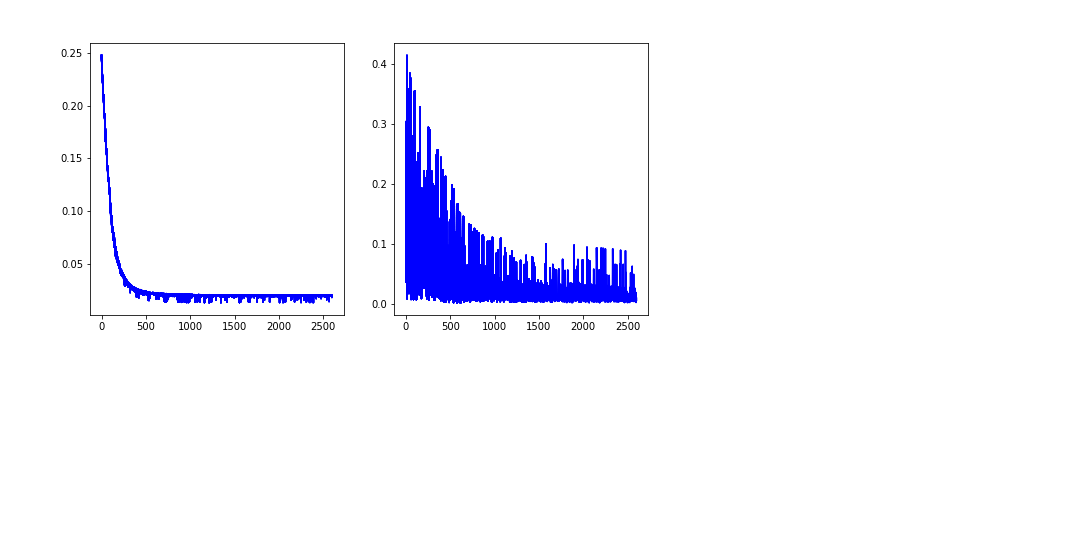

Epoch: 002687 vloss: 0.02 mloss: 0.004327 |██-----------------------| 10.8% Complete
Stopped


In [29]:
%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'

EPOCHS = 25000

rnn.optimizer = optim.RMSprop(rnn.parameters(), lr=0.0001)

mloss_boost = 1

printProgressBar(0, EPOCHS, prefix = 'Progress:', suffix = 'Complete', length = 25)

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,5))
fig.show()

for epoch in range(EPOCHS):
    try:
        rnn.optimizer.zero_grad()
        
        trn_V, trn_P, visual_input, motor_input, visual_target, motor_target = get_sample(device)
        
        # mu will be used as the initial hidden state. We forward only the first 
        # frame (+ maybe? initial joint states) of the sequence to get the hidden state.
        with torch.no_grad():
            _, mu, _ = vae(visual_input[0].unsqueeze(0), False) 
            hidden = mu.unsqueeze(1)/35.

        visual_output, motor_output, hidden = rnn(visual_input[1:, :,:,:].view(-1,1,64,64),
                                          motor_input[1:, :].view(-1, 2)/64., hidden)

        motor_loss = criterion0(motor_output, motor_target[1:, :].view(-1,2)/64.)
        visual_loss = criterion1(visual_output, visual_target[1:,:,:,:].view(-1,1,64,64))
        
        visual_mult, motor_mult = loss_balancer2(visual_loss.item(), motor_loss.item(), mloss_boost)
        loss = motor_mult*motor_loss + visual_mult*visual_loss
#         loss = motor_loss + visual_loss
        
        loss.backward()
        
        VLOSS.append(visual_loss.item())
        MLOSS.append(motor_loss.item())
        
        rnn.optimizer.step()
       
        printProgressBar(epoch + 1,
                         EPOCHS, 
                         prefix='Epoch: {} vloss: {:.2f} mloss: {:.6f}'.format(
                             str(epoch).zfill(6),
                             visual_loss.item(),
                             motor_loss.item()), 
                         suffix='Complete',
                         length=25)
        
#         if epoch % 1000 == 0:
#             torch.save(rnn.state_dict(), 'checkpoint')
            
        if epoch % 100 == 0:
            ax0.plot(VLOSS, c='b')
            ax1.plot(MLOSS, c='b')
            fig.canvas.draw()
            
    except KeyboardInterrupt:
        %matplotlib inline
        print('\nStopped')
        break
        

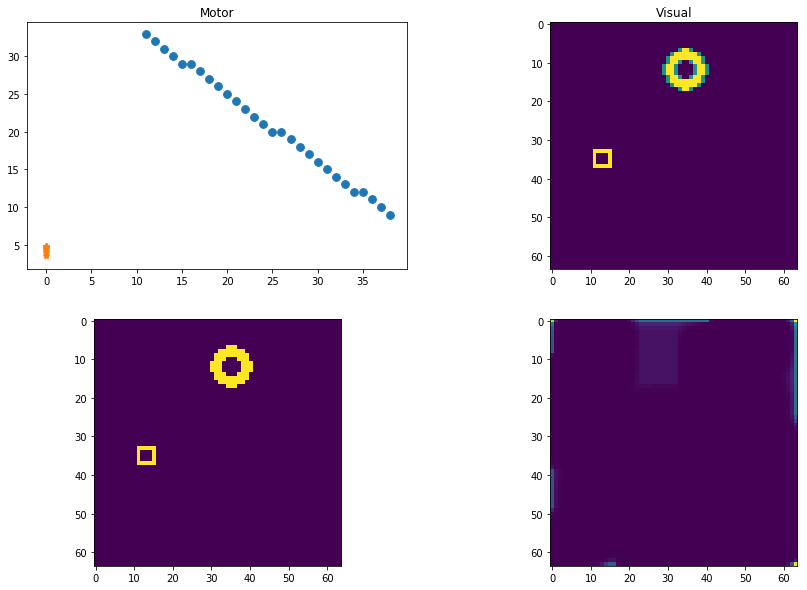

In [31]:
%matplotlib inline

trn_V, trn_P, visual_input, motor_input, visual_target, motor_target = get_sample(device)

with torch.no_grad():
    _, hidden, logsig = vae(visual_input[0].unsqueeze(0), False) 
    hidden.unsqueeze_(0)

visual_output, motor_output, hidden = rnn(visual_input[1:].view(-1,1,64,64),
                                          motor_input[1:].view(-1, 2), hidden)

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2,figsize=(15,10))
ax0.scatter(motor_target[:,0].cpu().detach().numpy(),
            motor_target[:,1].cpu().detach().numpy(), marker='o', s=60, label='input')
ax0.scatter(motor_output[:,0].cpu().detach().numpy(),
            motor_output[:,1].cpu().detach().numpy(), marker='*', label='output')
ax0.set(title='Motor')
ax1.set(title='Visual')
ax1.imshow(visual_input[4].cpu().detach().numpy().squeeze() + visual_target[4].cpu().detach().numpy().squeeze())

ax2.imshow(visual_input[4].cpu().detach().numpy().squeeze())
ax3.imshow(visual_output[4].cpu().detach().numpy().squeeze())


(array([ 72., 193., 481., 543., 670., 744., 568., 471., 159.,  99.]),
 array([-28.427746 , -22.817442 , -17.20714  , -11.596836 ,  -5.9865327,
         -0.3762293,   5.234074 ,  10.8443775,  16.454681 ,  22.064983 ,
         27.675287 ], dtype=float32),
 <a list of 10 Patch objects>)

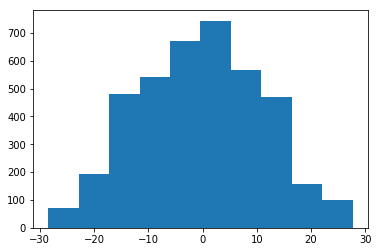

In [198]:
MU = []
for i in range(1000):
    trn_V, trn_P, visual_input, motor_input, visual_target, motor_target = get_sample(device)
    with torch.no_grad():
        _, mu, _ = vae(visual_input[0].unsqueeze(0), False) 
    MU.append(mu.cpu().detach().numpy())
    
plt.hist(np.stack(MU).flatten())

In [203]:
visual_output.max()

tensor(0.1206, device='cuda:0', grad_fn=<MaxBackward1>)

In [204]:
motor_input.max()

tensor(31., device='cuda:0')

In [207]:
motor_output.max()

tensor(3.6805, device='cuda:0', grad_fn=<MaxBackward1>)